In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import glob
import scipy
import json

import math
from matplotlib.lines import Line2D

import seaborn as sns

from tools.tools import *


import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel


In [2]:
root = "./data"

radius = 5.5e-6 #Bead size m
rho = 1.3 * 1000 #Bead density kg/m^3
mu_0 = 4*np.pi*1e-7 #permeability
phase = 5

time_s = 80; time_e = 300
m = 3.5/(10*0.3*3.3)*1e-6

T_0 = 25
r_T_0 = 0.971e3
v = 30000e-6

# our experiments
T = 23
a = 9.2e-4
b = 4.5e-7
r_ = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
nn = v*r_

#Parameters to crop simulation
height_px  = 1544 #height of FoV in µm
width_px = 2064 #width of FoV in µm

height = 1544*m #height of FoV in µm
width = 2064*m #width of FoV in µm

start_w =  0#0.0035 - width #flip
end_w = width

start_h = 0.003 - height/2; 
end_h = 0.003 + height/2

## Calibration Pulses

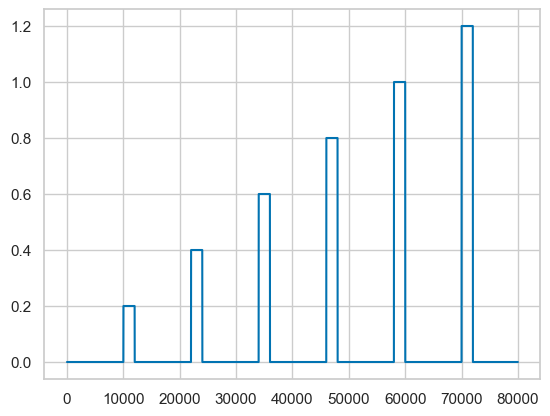

In [3]:
# ...existing code...
FreqRet = 1000  # Hz
time = 80
NSamples = time*FreqRet
sequence = np.zeros(NSamples)

slope = 0.2
i_max = 1.2
period = 2 # seconds
spacing = 10        # seconds

# optional: expose pulse metadata
pulses = []   # (t0_s, t1_s)
levels = []   # offsets

start_idx = int(1 * spacing * FreqRet)
for idx, i in enumerate(range(2, int(1.5 * i_max / slope))):
    if start_idx >= NSamples:
        break

    offset = slope * i - 0.2
    # fixed pulse duration for all pulses
    dur_samps = int(period * FreqRet)            # CHANGED: remove scaling by i
    end_idx = min(start_idx + dur_samps, NSamples)
    if end_idx <= start_idx:
        break

    sequence[start_idx:end_idx] = offset

    # record metadata in seconds
    # pulses.append(((start_idx+10) / FreqRet, ((end_idx)) / FreqRet)) #+start_idx
    pulses.append(((start_idx+10) / FreqRet, ((start_idx+end_idx)/2) / FreqRet)) #+start_idx
    levels.append(offset)

    # leave gap (no-moment) intact
    start_idx = end_idx + int(spacing * FreqRet)

plt.plot(sequence)
# ...existing code...

In [4]:

df_mg = []; df_ref = []

root = "."
path_multi_track = glob.glob(os.path.join("./results/calibs/calib_pulses_*/track.json"))
ref_flag = True; mg_flag = True
ref_label = 0; mg_label = 0 


for idx, current_path in enumerate(path_multi_track):
    
    t_ = np.array(pd.DataFrame(np.load(os.path.join(os.path.split(current_path)[0],"timestamps.npy")).T, columns=["1"])["1"])

    with open(current_path, "rb") as input_file:
        file_dict = json.load(input_file)

    for i in file_dict.keys():

        try:
            temp_df = pd.DataFrame(file_dict[i]).reset_index()
        except:
            print("error with ", current_path, "key", i)
            continue

        try:
            temp_df["t"] = t_[1:-1]#[time_s:time_e]
        except:
            print("error with time stamps:", current_path)
            continue

        temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],5)
        temp_df["y"] = (scipy.ndimage.gaussian_filter(temp_df["y"],5))

        temp_df["x_"] = (temp_df["x"]-temp_df["x"][0])*m
        temp_df["y_"] = (temp_df["y"]-temp_df["y"][0])*m

        temp_df["t"] = (temp_df["t"]-temp_df["t"][0])
        
        temp_df["y_scaled"] = temp_df["y"]*m
        temp_df["y_scaled"] -= height/2
        temp_df["x_scaled"] = temp_df["x"]*m 

        temp_df["r"] = np.sqrt(temp_df["x_"]**2 + temp_df["y_"]**2)
        temp_df["v"] = np.gradient(temp_df["r"], temp_df["t"])
        temp_df["force"] = scipy.ndimage.gaussian_filter(6*temp_df["v"].values*radius*np.pi*nn, 10)
        # temp_df["current"] = current_val

        parts = i.split("_")
        if parts[0] == "ref":
            temp_df["label"] = f"{idx}_{ref_label}"
            temp_df["type"] = "ref"
            ref_label += 1
            df_ref.append(temp_df)
        else:
            temp_df["type"] = "mg"
            temp_df["label"] = f"{idx}_{mg_label}"
            mg_label += 1
            df_mg.append(temp_df)
            # break

df_mg = pd.concat(df_mg).reset_index(drop=True)
df_ref = pd.concat(df_ref).reset_index(drop=True)
            
mm = df_mg.groupby(["label"]).mean(numeric_only=True).reset_index()
force = mm["force"].values
coords = np.stack((mm["x"].values*m,mm["y"].values*m),axis = 1)
y = force  # Shape: (n_samples,)
X = coords  # Shape: (n_samples, 2)
df_ = df_ref.copy()

error with time stamps: ./results/calibs\calib_pulses_1\track.json
error with  ./results/calibs\calib_pulses_1\track.json key ref_7
error with time stamps: ./results/calibs\calib_pulses_1\track.json
error with  ./results/calibs\calib_pulses_10\track.json key big_0
error with time stamps: ./results/calibs\calib_pulses_10\track.json
error with time stamps: ./results/calibs\calib_pulses_10\track.json
error with time stamps: ./results/calibs\calib_pulses_10\track.json
error with  ./results/calibs\calib_pulses_10\track.json key ref_6
error with  ./results/calibs\calib_pulses_2\track.json key big_4
error with time stamps: ./results/calibs\calib_pulses_2\track.json
error with  ./results/calibs\calib_pulses_2\track.json key ref_4
error with time stamps: ./results/calibs\calib_pulses_2\track.json
error with time stamps: ./results/calibs\calib_pulses_2\track.json
error with  ./results/calibs\calib_pulses_3\track.json key big_8
error with time stamps: ./results/calibs\calib_pulses_3\track.json
er

(-0.00027292929292929295, 0.00027292929292929295)

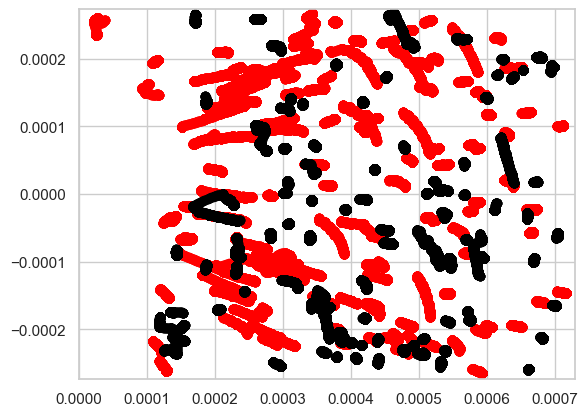

In [5]:
plt.scatter(df_mg["x_scaled"], df_mg["y_scaled"], color = "red")
plt.scatter(df_ref["x_scaled"], df_ref["y_scaled"], color = "black")
plt.xlim([0, width])
plt.ylim([-height/2, height/2])

C:\Users\lehto\AppData\Local\Temp\ipykernel_12888\2335041064.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = "t", y = "force", data=df_mg, style="label", palette="tab10")


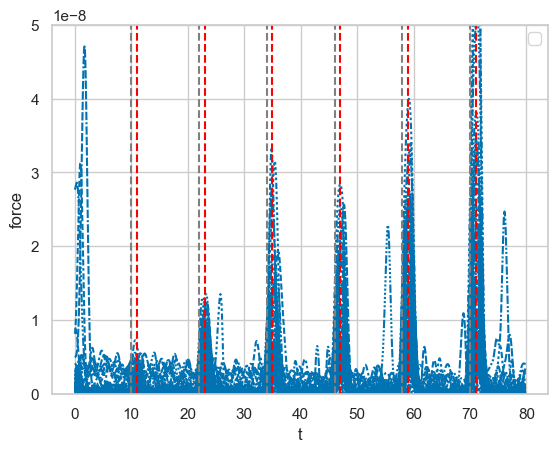

In [6]:
# pulses = [[10,15], [30,35], [55,60], [80,85], [105,110], [130,135]]

#Cut the first half of the first pulse to avoid artifacts from the start of the pulse

sns.lineplot(x = "t", y = "force", data=df_mg, style="label", palette="tab10")
plt.vlines([p[0] for p in pulses], ymin=df_mg["r"].min(), ymax=df_mg["r"].max(), color="gray", ls="--")
plt.vlines([p[1] for p in pulses], ymin=df_mg["r"].min(), ymax=df_mg["r"].max(), color="red", ls="--")
plt.ylim(0, 5e-8)
plt.legend("")

In [7]:
def _linfit_r_vs_t(g):
    global nn , radius
    """
    Calculate the slope force based on velocity, velocity derived from linear fit.
    Use linear fit to filter out bad slopes (e.g. due to tracking errors or non-moment periods). 
    Returns slope, intercept, R^2, and number of points used in the fit.
    """
    t = g["t"].to_numpy()
    r = g["r"].to_numpy()
    mask = np.isfinite(t) & np.isfinite(r)

    if mask.sum() < 3:
        return pd.Series({"slope_r": np.nan, "intercept_r": np.nan, "r2_r": np.nan, "n_pts": int(mask.sum())})
    
    t0 = t[mask] - t[mask].min()
    r0 = r[mask]

    slope, intercept = np.polyfit(t0, r0, 1)
    yhat = slope*t0 + intercept
    ss_res = np.sum((r0 - yhat)**2)
    ss_tot = np.sum((r0 - r0.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0             
    force  = 6*np.pi*nn*radius *slope

    x = np.mean(g["x_scaled"].to_numpy())
    y = np.mean(g["y_scaled"].to_numpy())
    return pd.Series({"force": force, "x": x, "y": y,"slope_r": slope, "intercept_r": intercept, "r2_r": r2, "n_pts": int(mask.sum())})


df_mg["pulse_idx"] = -1
idxs = np.full(df_mg.shape[0], -1, dtype=int)

t_series = df_mg["t"].values 
for k, (t0, t1) in enumerate(pulses):
    mask = (t_series >= t0) & (t_series < t1)
    idxs[mask] = k

df_mg["pulse_idx"] = idxs

# Map current level per pulse
if len(levels) >= len(pulses):
    level_map = {i: levels[i] for i in range(len(pulses))}
    df_mg["currents_level"] = pd.Series(df_mg["pulse_idx"]).map(level_map)
else:
    df_mg["currents_level"] = np.nan
        
mm = (
    df_mg.query("pulse_idx >= 0")
         .groupby(["label", "pulse_idx", "currents_level"], as_index=False)
         .mean(numeric_only=True)
)

slopes = (
    df_mg.query("pulse_idx >= 0")
         .groupby(["label","pulse_idx","currents_level"], as_index=False)
         .apply(_linfit_r_vs_t)
         .reset_index(drop=True)
)

slope_min = 0.0   
r2_min    = 0.7  # minimum fit quality

slopes["keep_slope"] = (slopes["slope_r"] >= slope_min) & (slopes["r2_r"] >= r2_min)

mm = slopes
n_before = mm.shape[0]
mm = mm[mm["keep_slope"].fillna(False)].copy()

print(f"Dropped {n_before - mm.shape[0]} pulse sets by slope QC (slope < {slope_min:.2e} m/s or R^2 < {r2_min:.2f}).")

force = mm["force"].to_numpy()
coords = np.stack((mm["x"].values*m, mm["y"].values*m), axis=1)

df_mg_keep = (
    df_mg.query("pulse_idx >= 0")
         .merge(slopes[["label","pulse_idx","currents_level","keep_slope"]],
                on=["label","pulse_idx","currents_level"], how="left")
)

Dropped 180 pulse sets by slope QC (slope < 0.00e+00 m/s or R^2 < 0.70).


C:\Users\lehto\AppData\Local\Temp\ipykernel_12888\1998620008.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_linfit_r_vs_t)


In [8]:
# Repeat the same for reference data

def _linfit_r_vs_t(g):

    global nn , radius
    t = g["t"].to_numpy()
    r = g["r"].to_numpy()
    mask = np.isfinite(t) & np.isfinite(r)
    if mask.sum() < 3:
        return pd.Series({"slope_r": np.nan, "intercept_r": np.nan, "r2_r": np.nan, "n_pts": int(mask.sum())})
    
    t0 = t[mask] - t[mask].min()
    r0 = r[mask]
    slope, intercept = np.polyfit(t0, r0, 1)
    yhat = slope*t0 + intercept
    ss_res = np.sum((r0 - yhat)**2)
    ss_tot = np.sum((r0 - r0.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0             
    force  = 6*np.pi*nn*radius *slope
    x = np.mean(g["x_scaled"].to_numpy())
    y = np.mean(g["y_scaled"].to_numpy())
    return pd.Series({"force": force, "x": x, "y": y,"slope_r": slope, "intercept_r": intercept, "r2_r": r2, "n_pts": int(mask.sum())})

df_ref["pulse_idx"] = -1

idxs = np.full(df_ref.shape[0], -1, dtype=int)

t_series = df_ref["t"].values  # must be on the same timebase as `pulses`
for k, (t0, t1) in enumerate(pulses):
    mask = (t_series >= t0) & (t_series < t1)
    idxs[mask] = k

df_ref["pulse_idx"] = idxs

# Map current level per pulse
if len(levels) >= len(pulses):
    level_map = {i: levels[i] for i in range(len(pulses))}
    df_ref["currents_level"] = pd.Series(df_ref["pulse_idx"]).map(level_map)
else:
    df_ref["currents_level"] = np.nan
        
mm_ref = (
    df_ref.query("pulse_idx >= 0")
         .groupby(["label", "pulse_idx", "currents_level"], as_index=False)
         .mean(numeric_only=True)
)
slopes_ref = (
    df_ref.query("pulse_idx >= 0")
         .groupby(["label","pulse_idx","currents_level"], as_index=False)
         .apply(_linfit_r_vs_t)
         .reset_index(drop=True)
)
slope_min = 0.0   
r2_min    = 0.7  # minimum fit quality

slopes_ref["keep_slope"] = (slopes_ref["slope_r"] >= slope_min) & (slopes_ref["r2_r"] >= r2_min)

mm_ref = slopes_ref
n_before = mm_ref.shape[0]
mm_ref = mm_ref[mm_ref["keep_slope"].fillna(False)].copy()

force_ref = mm_ref["force"].to_numpy()
velocity_ref = mm_ref["slope_r"].to_numpy()

coords = np.stack((mm_ref["x"].values*m,mm_ref["y"].values*m), axis=1)

df_ref_keep = (
    df_ref.query("pulse_idx >= 0")
         .merge(slopes_ref[["label","pulse_idx","currents_level","keep_slope"]],
                on=["label","pulse_idx","currents_level"], how="left")
)

C:\Users\lehto\AppData\Local\Temp\ipykernel_12888\1824725177.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_linfit_r_vs_t)


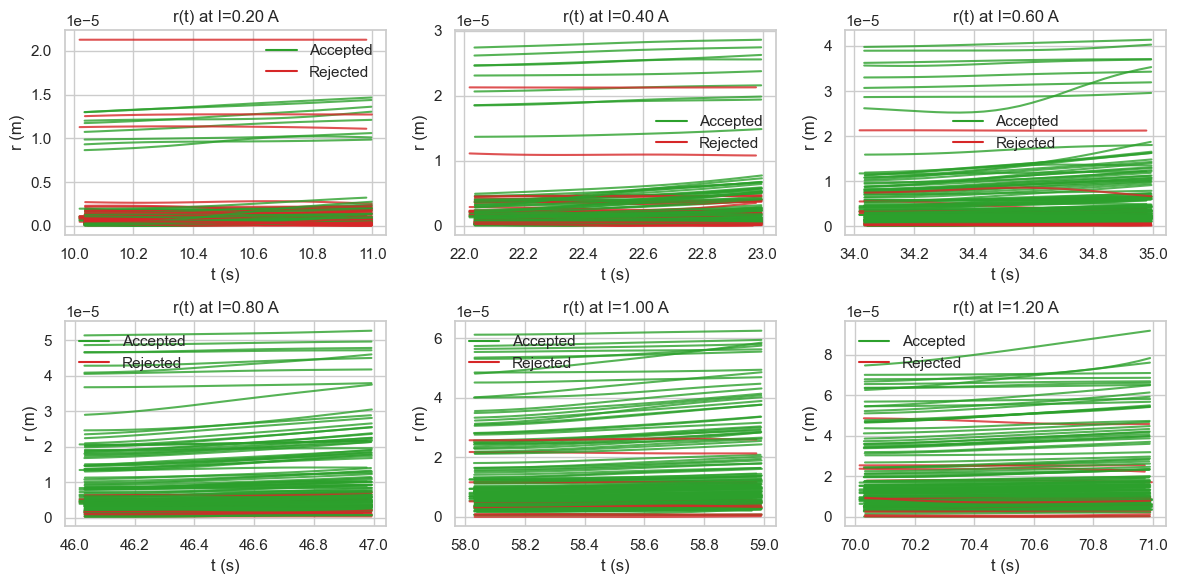

In [9]:


levels = df_mg_keep["currents_level"].dropna().unique()
n_levels = len(levels)
n_cols = 3
n_rows = math.ceil(n_levels / n_cols) if n_levels > 0 else 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), squeeze=False)
for idx, (i_level, data) in enumerate(df_mg_keep.groupby("currents_level", sort=True)):
    r, c = divmod(idx, n_cols)
    axis = ax[r, c]

    for lbl, g in data.groupby("label"):
        ok = bool(g["keep_slope"].iloc[0])
        color = "tab:green" if ok else "tab:red"
        axis.plot(g["t"].to_numpy(), g["r"].to_numpy(), color=color, alpha=0.8)

    axis.set_title(f"r(t) at I={i_level:.2f} A")
    axis.set_xlabel("t (s)")
    axis.set_ylabel("r (m)")

    handles = [
        Line2D([0], [0], color="tab:green", label="Accepted"),
        Line2D([0], [0], color="tab:red", label="Rejected"),
    ]
    axis.legend(handles=handles, frameon=False)


plt.tight_layout()
plt.show()





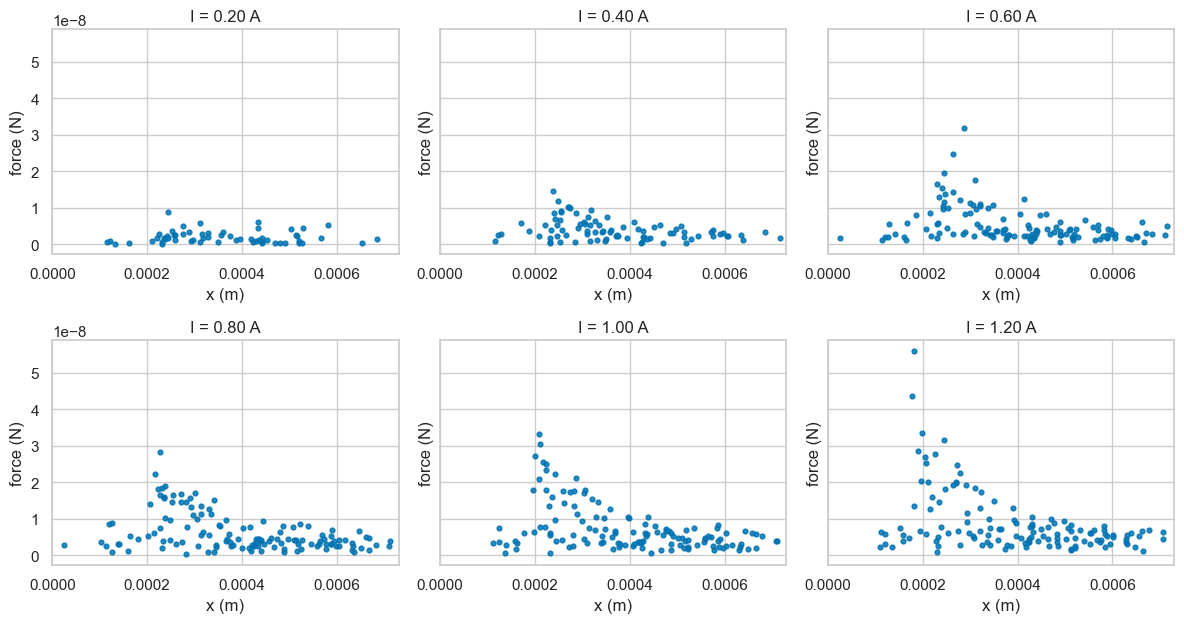

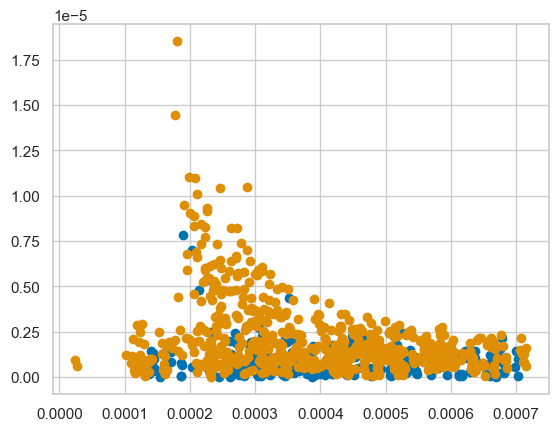

In [10]:
import math

# Subplots by current level: x vs force
levels = sorted([lv for lv in mm["currents_level"].dropna().unique()])
n_levels = len(levels)

n_cols = 3
n_rows = math.ceil(n_levels / n_cols) if n_levels > 0 else 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.2 * n_rows), squeeze=False, sharey=True)

# Consistent y-range for comparability
if n_levels > 0 and "force" in mm:
    ymin = float(np.nanmin(mm["force"]))
    ymax = float(np.nanmax(mm["force"]))
    span = ymax - ymin if ymax > ymin else 1.0
    ymin_m = ymin - 0.05 * span
    ymax_m = ymax + 0.05 * span
else:
    ymin_m, ymax_m = None, None

for idx, level in enumerate(levels):
    r, c = divmod(idx, n_cols)
    ax = axes[r, c]
    sub = mm.loc[mm["currents_level"] == level]
    ax.scatter(sub["x"], sub["force"], s=12, alpha=0.85)
    ax.set_title(f"I = {level:.2f} A")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("force (N)")
    ax.set_xlim(0, width)
    if ymin_m is not None:
        ax.set_ylim(ymin_m, ymax_m)


plt.tight_layout()
plt.show()

plt.scatter(mm_ref["x"], mm_ref["slope_r"])
plt.scatter(mm["x"], mm["slope_r"])

In [11]:
# ...existing code...
import plotly.express as px

mm_plot = mm.sort_values("pulse_idx").copy()
mm_plot["x_m"] = mm_plot["x"] 
mm_plot["y_m"] = mm_plot["y"] 

fig = px.scatter_3d(
    mm_plot,
    x="x_m", y="y_m", z="force",
    color="currents_level",
    color_continuous_scale="Viridis",
    # symbol="label",  # removed: no legend for labels
    hover_data=["label", "pulse_idx"]
)

fig.update_layout(
    template="plotly_white",
    scene=dict(xaxis_title="x (m)", yaxis_title="y (m)", zaxis_title="force (N)"),
    showlegend=False  # hide any symbol legend
)

# Clean colorbar ticks (optional)
vals = sorted(mm_plot["currents_level"].unique())
fig.update_layout(coloraxis_colorbar=dict(
    title="current level (A)",
    tickvals=vals,
    ticktext=[f"{v:.2f}" for v in vals]
))

# plt.ylim([-height/2, height/2])
# plt.xlim([0, width])
fig.show()
# ...existing code...

## Calculate reference and mg force fields separately

In [12]:
mm_fit = mm_plot.dropna(subset=["x_m","y_m","currents_level","force", "slope_r"]).copy()
mm_fit.to_csv("./results/mg_calib_slopes.csv", index=False)

KRR best: {'alpha': 20.0, 'gamma': 10.0, 'kernel': 'rbf'}


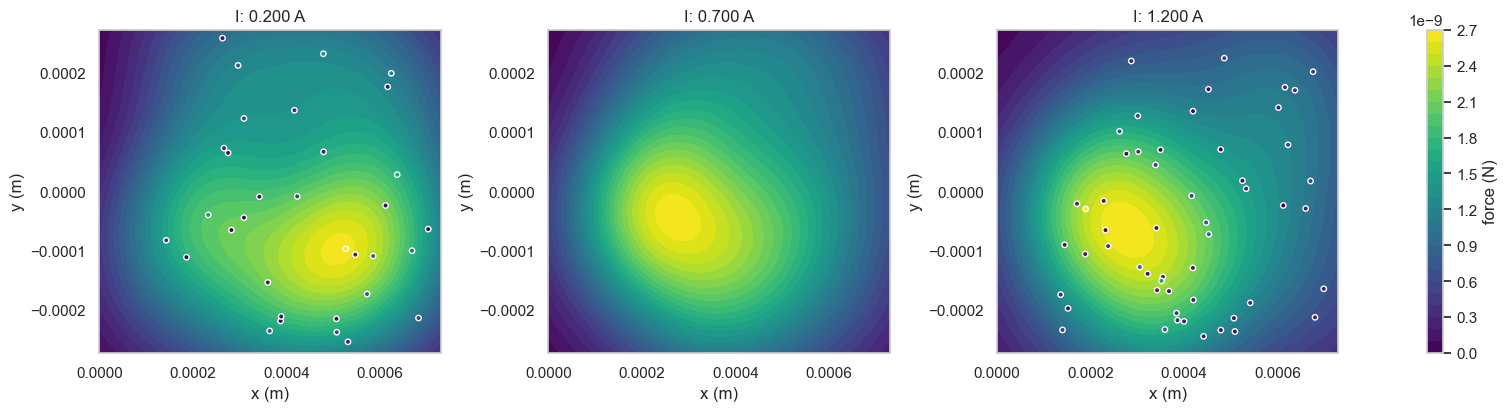

In [13]:

#Fit KRR to the reference data to get a smooth velocity field to be reduced from magnetic beads

mm_ref_plot = mm_ref.sort_values("pulse_idx").copy()
mm_ref_plot["x_m"] = mm_ref_plot["x"]
mm_ref_plot["y_m"] = mm_ref_plot["y"]

X3 = mm_ref_plot[["x_m","y_m","currents_level"]].to_numpy()
y3 = mm_ref_plot["force"].to_numpy() #slope_r

# Scale
sx_ref = MinMaxScaler(); sy_ref = MinMaxScaler()

X3_s = sx_ref.fit_transform(X3)
y3_s = sy_ref.fit_transform(y3.reshape(-1,1)).ravel()

# KRR search parameters
alpha_grid = np.linspace(20, 20, 100)
gamma_grid = np.linspace(10, 20, 100)
param_grid = {
    "alpha": alpha_grid,
    "kernel": ["rbf"],
    "gamma": gamma_grid,
}

krr3_ref = GridSearchCV(KernelRidge(), param_grid, cv=4, n_jobs=-1)
krr3_ref.fit(X3_s, y3_s)
print("KRR best:", krr3_ref.best_params_)

# Prediction grid
nx, ny, ni = 60, 60, 15
xg = np.linspace(0, width, nx)
yg = np.linspace(-height/2, height/2, ny)
ig = np.linspace(mm_ref_plot["currents_level"].min(), mm_ref_plot["currents_level"].max(), ni)

XX, YY, II = np.meshgrid(xg, yg, ig, indexing="xy")     # (ny, nx, ni)
Xgrid = np.stack([XX.ravel(), YY.ravel(), II.ravel()], axis=1)

Ypred_krr = sy_ref.inverse_transform(
    krr3_ref.best_estimator_.predict(sx_ref.transform(Xgrid)).reshape(-1,1)
).ravel()

krr_pred_ref = Ypred_krr.reshape(ny, nx, ni)

# Visualize 3 current slices
fig, axes = plt.subplots(1, 3, figsize=(15,4), constrained_layout=True)
slice_ids = [0, ni//2, ni-1]

for ax, k in zip(axes, slice_ids):
    cs = ax.contourf(xg, yg, krr_pred_ref[:,:,k], levels=28, cmap="viridis")
    i_k = ig[k]

    sl = mm_ref_plot[np.isfinite(mm_ref_plot["currents_level"]) & (np.abs(mm_ref_plot["currents_level"]-i_k) <= (0.02*np.ptp(ig)))] #current level was float....

    ax.scatter(sl["x_m"], sl["y_m"], c=sl["force"], cmap="viridis", edgecolor="w", s=15)
    ax.set_title(f"I: {i_k:.3f} A"); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, width])


fig.colorbar(cs, ax=axes, label="force (N)")
row_idx = 30
col_idx = 6
plt.show()



In [22]:
import sklearn
import joblib
import time

def save_model_bundle(model, sx, sy, out_path, feature_order, target_name, extra_meta=None):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    bundle = {
        "model": model,
        "sx": sx,           # feature scaler
        "sy": sy,           # target scaler
        "feature_order": feature_order,
        "target_name": target_name,
        "meta": {
            "saved_at": time.strftime("%Y-%m-%d %H:%M:%S"),
            "sklearn_version": sklearn.__version__,
            **(extra_meta or {})
        }
    }
    joblib.dump(bundle, out_path)
    print(f"Saved: {out_path}")

out_dir = "./results"
feature_order = ["x_m", "y_m", "currents_level"]
target_name = "force"

# Save KRR with  scaler `
save_model_bundle(
    krr3_ref, sx_ref, sy_ref,
    os.path.join(out_dir, "force_krr_ref_v2.joblib"),
    feature_order, target_name,
    extra_meta={"model_type": "KernelRidge(RBF)", "scaler_type": type(sy_ref).__name__}
)




Saved: ./results\force_krr_ref_v2.joblib


KRR best: {'alpha': 20.0, 'gamma': 10.0, 'kernel': 'rbf'}


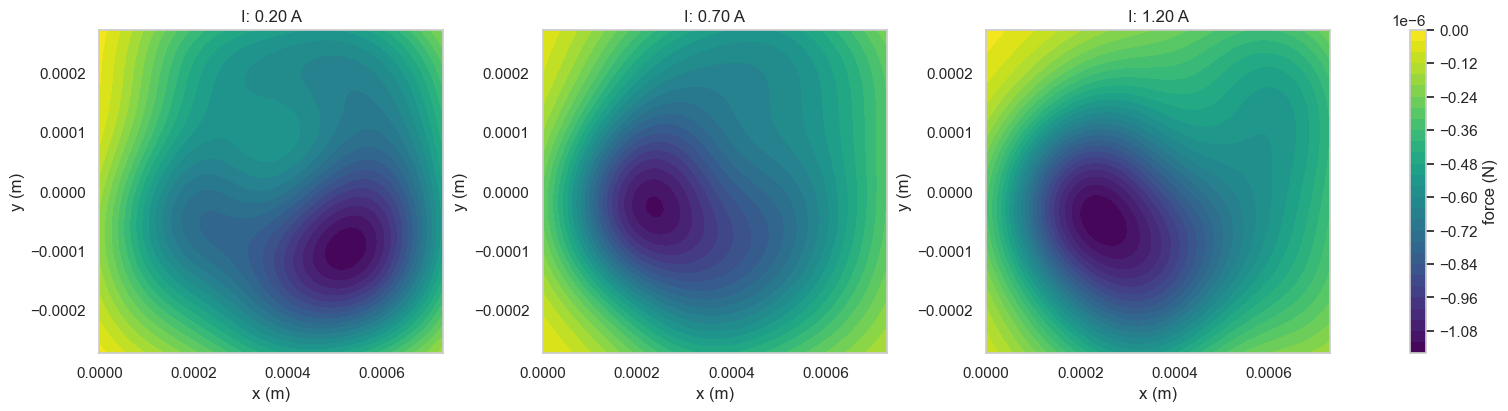

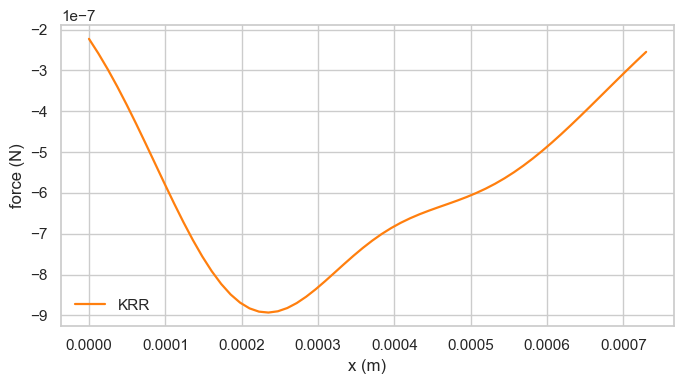

In [23]:
#Then fit KRR to the corrected force values to get a smooth force field to be reduced from magnetic beads

X3 = mm_fit[["x_m","y_m","currents_level"]].to_numpy()
y3 = mm_fit["force"].to_numpy()

sx = MinMaxScaler(); sy = MinMaxScaler()
X3_s = sx.fit_transform(X3)
y3_s = sy.fit_transform(y3.reshape(-1,1)).ravel()

alpha_grid = np.linspace(20, 20, 100)
gamma_grid = np.linspace(10, 20, 100)
param_grid = {
    "alpha": alpha_grid,
    "kernel": ["rbf"],
    "gamma": gamma_grid,
}

krr3 = GridSearchCV(KernelRidge(), param_grid, cv=4, n_jobs=-1)
krr3.fit(X3_s, y3_s)
print("KRR best:", krr3.best_params_)

# Prediction grid
nx, ny, ni = 60, 60, 15
xg = np.linspace(0, width, nx)
yg = np.linspace(-height/2, height/2, ny)
ig = np.linspace(mm_fit["currents_level"].min(), mm_fit["currents_level"].max(), ni)

XX, YY, II = np.meshgrid(xg, yg, ig, indexing="xy")     # (ny, nx, ni)
Xgrid = np.stack([XX.ravel(), YY.ravel(), II.ravel()], axis=1)

Ypred_krr = sy.inverse_transform(
    krr3.best_estimator_.predict(sx.transform(Xgrid)).reshape(-1,1)
).ravel()

krr_pred = Ypred_krr.reshape(ny, nx, ni) - krr_pred_ref


fig, axes = plt.subplots(1, 3, figsize=(15,4), constrained_layout=True)
slice_ids = [0, ni//2, ni-1]

for ax, k in zip(axes, slice_ids):
    cs = ax.contourf(xg, yg, krr_pred[:,:,k], levels=28, cmap="viridis")
    # overlay nearby measurements at this current
    i_k = ig[k]
    # sl = mm_fit[np.isfinite(mm_fit["currents_level"]) & (np.abs(mm_fit["currents_level"]-i_k) <= (0.02*np.ptp(ig)))]
    # ax.scatter(sl["x_m"], sl["y_m"], c=sl["force_corr"], cmap="viridis", edgecolor="w", s=15)
    ax.set_title(f"I: {i_k:.2f} A"); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")

    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, width])

fig.colorbar(cs, ax=axes, label="force (N)")
row_idx = 30
col_idx = 6
plt.show()
plt.figure(figsize=(7,4))
plt.plot(xg, krr_pred[row_idx, :, col_idx], label="KRR", color="tab:orange", lw=1.6)
plt.xlabel("x (m)"); plt.ylabel("force (N)")
plt.legend(frameon=False)
plt.tight_layout(); plt.show()


In [24]:
import sklearn
import joblib
import time

def save_model_bundle(model, sx, sy, out_path, feature_order, target_name, extra_meta=None):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    bundle = {
        "model": model,
        "sx": sx,           # feature scaler
        "sy": sy,           # target scaler
        "feature_order": feature_order,
        "target_name": target_name,
        "meta": {
            "saved_at": time.strftime("%Y-%m-%d %H:%M:%S"),
            "sklearn_version": sklearn.__version__,
            **(extra_meta or {})
        }
    }
    joblib.dump(bundle, out_path)
    print(f"Saved: {out_path}")

out_dir = "./results"
feature_order = ["x_m", "y_m", "currents_level"]
target_name = "force"

# Save KRR with  scaler `
save_model_bundle(
    krr3, sx, sy,
    os.path.join(out_dir, "force_krr_mg_v2.joblib"),
    feature_order, target_name,
    extra_meta={"model_type": "KernelRidge(RBF)", "scaler_type": type(sy).__name__}
)




Saved: ./results\force_krr_mg_v2.joblib


Relative average difference 0.15033941876276163


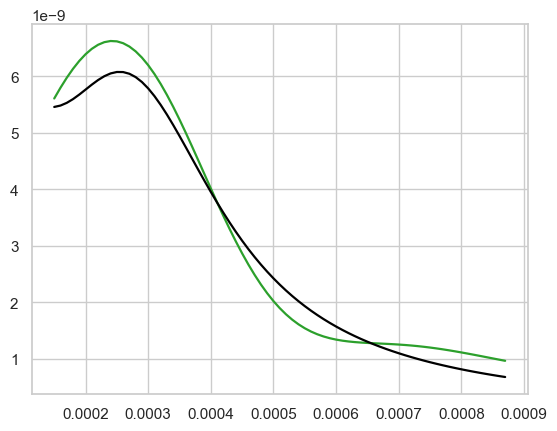

In [25]:
import h5py

with h5py.File("./results/force_model.h5", "r") as f:
    force_control= f["model/force_field"][...]
    f2i = f["model/F2I"][...]
    x_axis = f["model/x"][...]+1.5e-4 #shift the simulation data to match empirical position
    y_axis = f["model/y"][...]
    i_axis = f["model/i"][...]
    
level = 12

i_l = 9
y_l = 29

X_line = np.stack([x_axis, np.full_like(x_axis, y_axis[y_l]), np.full_like(x_axis, i_axis[i_l])], axis=1)

mu_s_line = krr3.predict(sx.transform(X_line))
mu_line = sy.inverse_transform(mu_s_line.reshape(-1, 1)).ravel()

mu_s_ref_line = krr3_ref.predict(sx_ref.transform(X_line))
mu_ref_line = sy_ref.inverse_transform(mu_s_ref_line.reshape(-1, 1)).ravel()

mu_line -= mu_ref_line

r_diff = np.abs((mu_line - force_control[y_l, :, i_l])/ force_control[y_l, :, i_l])
print("Relative average difference", np.mean(r_diff))

plt.plot(x_axis, mu_line, label="Saved model", color="tab:green", lw=1.6)
plt.plot(x_axis, force_control[y_l, :, i_l], label="Saved model", color="black", lw=1.6)

## Reference velocity field reduction before force field computation

KRR best: {'alpha': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}


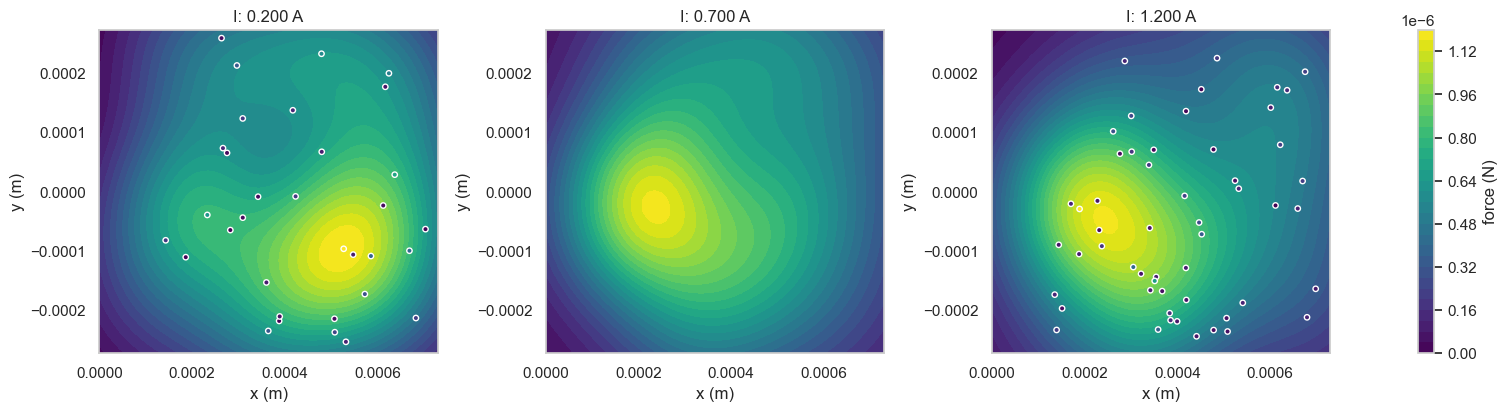

In [18]:

#Fit KRR to the reference data to get a smooth velocity field to be reduced from magnetic beads

mm_ref_plot = mm_ref.sort_values("pulse_idx").copy()
mm_ref_plot["x_m"] = mm_ref_plot["x"]
mm_ref_plot["y_m"] = mm_ref_plot["y"]

X3 = mm_ref_plot[["x_m","y_m","currents_level"]].to_numpy()

y3 = mm_ref_plot["slope_r"].to_numpy() #slope_r

# Scale
sx = MinMaxScaler(); sy = MinMaxScaler()

X3_s = sx.fit_transform(X3)
y3_s = sy.fit_transform(y3.reshape(-1,1)).ravel()

# KRR search parameters
alpha_grid = np.linspace(10, 20, 100)
gamma_grid = np.linspace(10, 20, 100)
param_grid = {
    "alpha": alpha_grid,
    "kernel": ["rbf"],
    "gamma": gamma_grid,
}

krr3 = GridSearchCV(KernelRidge(), param_grid, cv=4, n_jobs=-1)
krr3.fit(X3_s, y3_s)
print("KRR best:", krr3.best_params_)

# Prediction grid
nx, ny, ni = 60, 60, 15
xg = np.linspace(0, width, nx)
yg = np.linspace(-height/2, height/2, ny)
ig = np.linspace(mm_ref_plot["currents_level"].min(), mm_ref_plot["currents_level"].max(), ni)

XX, YY, II = np.meshgrid(xg, yg, ig, indexing="xy")     # (ny, nx, ni)
Xgrid = np.stack([XX.ravel(), YY.ravel(), II.ravel()], axis=1)

Ypred_krr = sy.inverse_transform(
    krr3.best_estimator_.predict(sx.transform(Xgrid)).reshape(-1,1)
).ravel()

krr_pred_ref = Ypred_krr.reshape(ny, nx, ni)

# Visualize 3 current slices
fig, axes = plt.subplots(1, 3, figsize=(15,4), constrained_layout=True)
slice_ids = [0, ni//2, ni-1]

for ax, k in zip(axes, slice_ids):
    cs = ax.contourf(xg, yg, krr_pred_ref[:,:,k], levels=28, cmap="viridis")
    i_k = ig[k]

    sl = mm_ref_plot[np.isfinite(mm_ref_plot["currents_level"]) & (np.abs(mm_ref_plot["currents_level"]-i_k) <= (0.02*np.ptp(ig)))] #current level was float....

    ax.scatter(sl["x_m"], sl["y_m"], c=sl["force"], cmap="viridis", edgecolor="w", s=15)
    ax.set_title(f"I: {i_k:.3f} A"); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, width])


fig.colorbar(cs, ax=axes, label="force (N)")
row_idx = 30
col_idx = 6
plt.show()



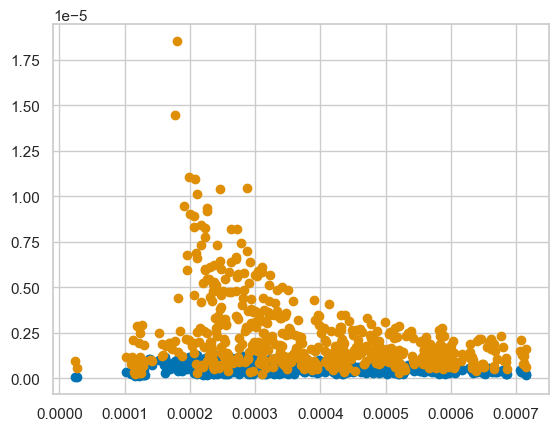

In [19]:
mm_fit = mm_plot.dropna(subset=["x_m","y_m","currents_level","force", "slope_r"]).copy()

y_pred_scaled = krr3.predict(sx.transform(mm_fit[["x_m","y_m","currents_level"]].to_numpy()))
y_pred = sy.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
plt.scatter(mm_fit["x_m"], y_pred)
mm_fit["v_corr"] = mm_fit["slope_r"] - y_pred

mm_fit = mm_fit[mm_fit["v_corr"] >= 0].copy()
mm_fit["force_corr"] = 6*np.pi*nn*radius * mm_fit["v_corr"]

plt.scatter(mm_fit["x_m"], mm_fit["slope_r"])



KRR best: {'alpha': 20.0, 'gamma': 10.0, 'kernel': 'rbf'}


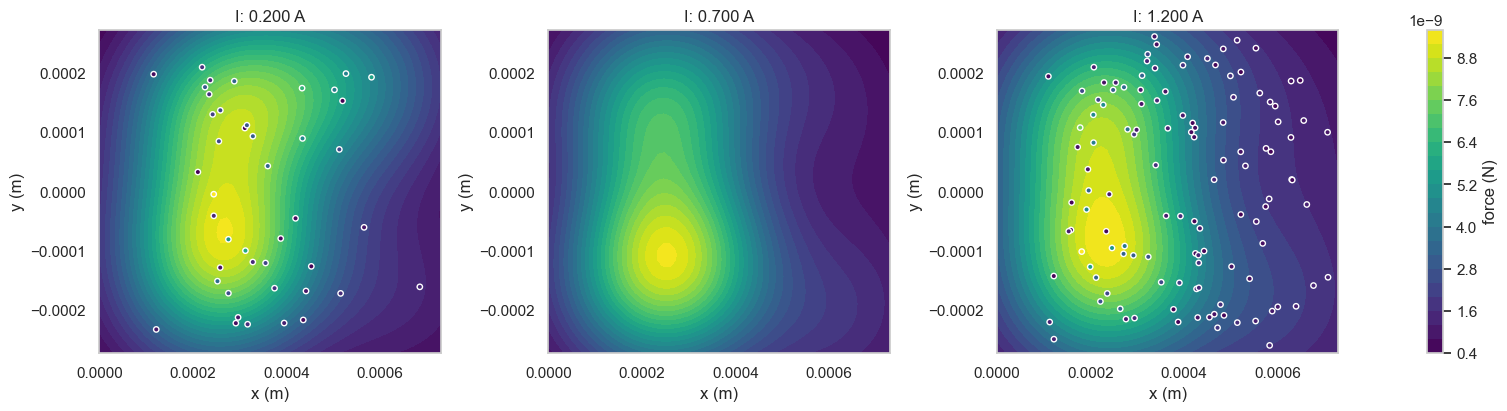

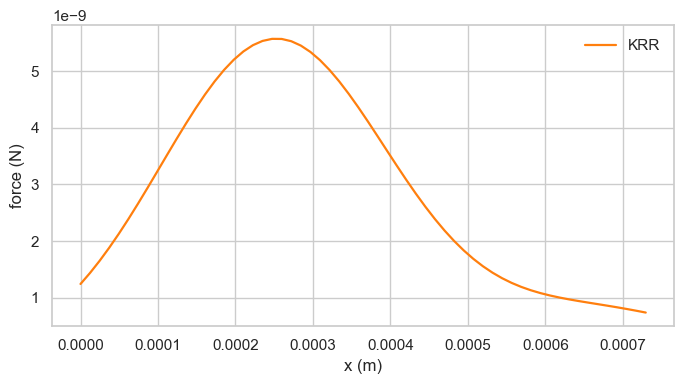

In [20]:
#Then fit KRR to the corrected force values to get a smooth force field to be reduced from magnetic beads

X3 = mm_fit[["x_m","y_m","currents_level"]].to_numpy()
y3 = mm_fit["force_corr"].to_numpy()
sx = MinMaxScaler(); sy = MinMaxScaler()
X3_s = sx.fit_transform(X3)
y3_s = sy.fit_transform(y3.reshape(-1,1)).ravel()

alpha_grid = np.linspace(20, 20, 100)
gamma_grid = np.linspace(10, 20, 100)
param_grid = {
    "alpha": alpha_grid,
    "kernel": ["rbf"],
    "gamma": gamma_grid,
}

krr3 = GridSearchCV(KernelRidge(), param_grid, cv=4, n_jobs=-1)
krr3.fit(X3_s, y3_s)
print("KRR best:", krr3.best_params_)

# Prediction grid
nx, ny, ni = 60, 60, 15
xg = np.linspace(0, width, nx)
yg = np.linspace(-height/2, height/2, ny)
ig = np.linspace(mm_fit["currents_level"].min(), mm_fit["currents_level"].max(), ni)

XX, YY, II = np.meshgrid(xg, yg, ig, indexing="xy")     # (ny, nx, ni)
Xgrid = np.stack([XX.ravel(), YY.ravel(), II.ravel()], axis=1)

Ypred_krr = sy.inverse_transform(
    krr3.best_estimator_.predict(sx.transform(Xgrid)).reshape(-1,1)
).ravel()

krr_pred = Ypred_krr.reshape(ny, nx, ni)


fig, axes = plt.subplots(1, 3, figsize=(15,4), constrained_layout=True)
slice_ids = [0, ni//2, ni-1]

for ax, k in zip(axes, slice_ids):
    cs = ax.contourf(xg, yg, krr_pred[:,:,k], levels=28, cmap="viridis")
    # overlay nearby measurements at this current
    i_k = ig[k]
    sl = mm_fit[np.isfinite(mm_fit["currents_level"]) & (np.abs(mm_fit["currents_level"]-i_k) <= (0.02*np.ptp(ig)))]
    ax.scatter(sl["x_m"], sl["y_m"], c=sl["force_corr"], cmap="viridis", edgecolor="w", s=15)
    ax.set_title(f"I: {i_k:.3f} A"); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")

    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, width])

fig.colorbar(cs, ax=axes, label="force (N)")
row_idx = 30
col_idx = 6
plt.show()
plt.figure(figsize=(7,4))
plt.plot(xg, krr_pred[row_idx, :, col_idx], label="KRR", color="tab:orange", lw=1.6)
plt.xlabel("x (m)"); plt.ylabel("force (N)")
plt.legend(frameon=False)
plt.tight_layout(); plt.show()


c:\Users\lehto\anaconda3\envs\proto\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 8.268285205237851e-09. Decreasing the bound and calling fit again may find a better value.



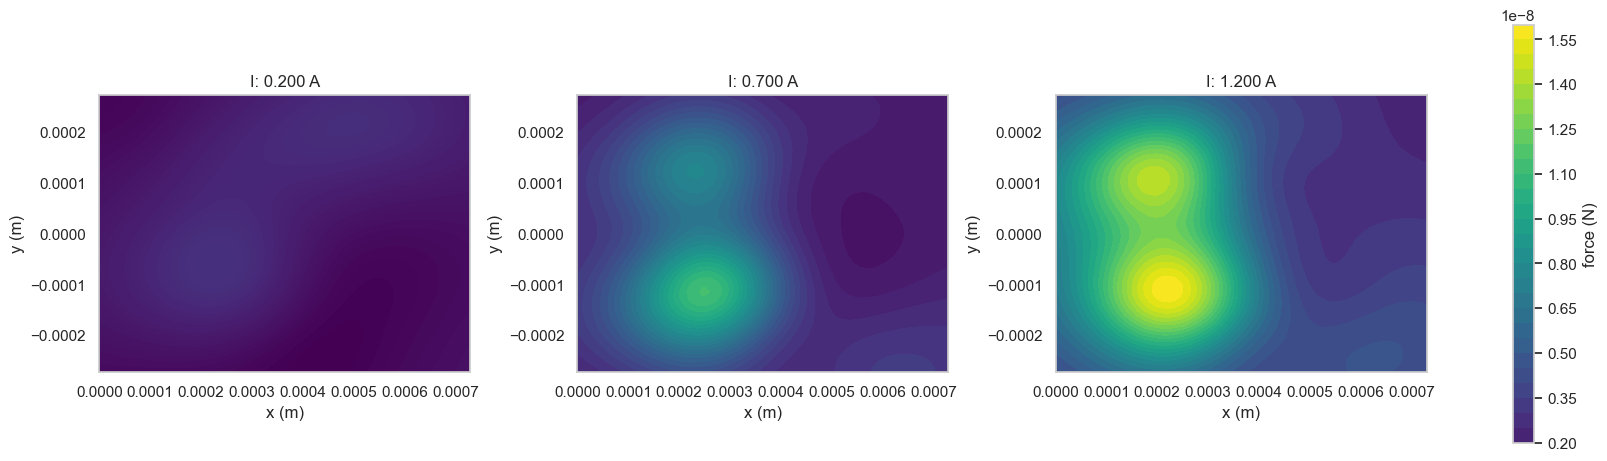

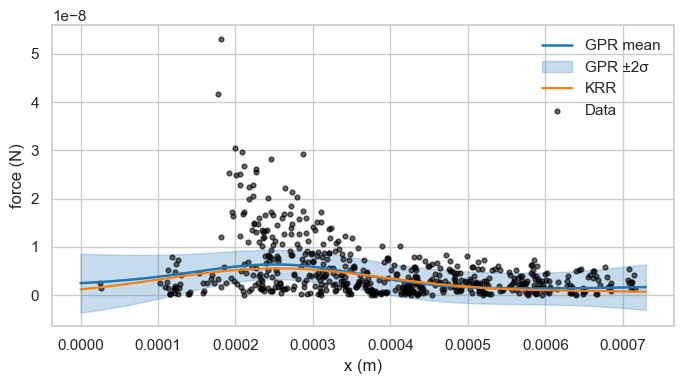

In [21]:

# Then, fit gaussian process regression to the corrected force also to get uncertainty estimates

row_idx = 30
col_idx = 6

#Noise value hyperparameters based on KRR residuals, and others based on feeling and fitting
# Purpose is just to fit the current data

yhat_s = krr3.best_estimator_.predict(X3_s)
resid_s = (y3_s - yhat_s).ravel()
noise_init = float(np.nanvar(resid_s))
noise_lb = noise_init*1e-6
noise_ub = noise_init*1e3

kernel_global = (
    ConstantKernel(1.0, (1e-4, 1e4))
    * RationalQuadratic(
        length_scale=5,
        alpha=0.9, #0.9,
        length_scale_bounds=(0.1, 30.0),
        alpha_bounds=(0.4, 2.5),
    )
    + WhiteKernel(noise_level=noise_init, noise_level_bounds=(noise_lb, noise_ub))
)

gpr = GaussianProcessRegressor(
    kernel=kernel_global,
    alpha=1.2e-2,         
    n_restarts_optimizer=12,
    random_state=42,
    normalize_y=False,
)

# Fit
gpr.fit(X3_s, y3_s)


mu_s, std_s = gpr.predict(sx.transform(Xgrid), return_std=True)
mu = sy.inverse_transform(mu_s.reshape(-1, 1)).ravel()
gpr_pred = mu.reshape(ny, nx, ni)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), constrained_layout=True)
slice_ids = [0, ni // 2, ni - 1]
vmin = float(np.nanmin(gpr_pred[:, :, slice_ids]))
vmax = float(np.nanmax(gpr_pred[:, :, slice_ids]))

for ax, k in zip(axes, slice_ids):
    cs = ax.contourf(xg, yg, gpr_pred[:, :, k], levels=28, cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(f"I: {ig[k]:.3f} A")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, width])

fig.colorbar(cs, ax=axes, label="force (N)")
plt.show()


y_val = yg[row_idx]
i_val = ig[col_idx]

X_line = np.stack([xg, np.full_like(xg, y_val), np.full_like(xg, i_val)], axis=1)
mu_s_line, std_s_line = gpr.predict(sx.transform(X_line), return_std=True)

mu_line = sy.inverse_transform(mu_s_line.reshape(-1, 1)).ravel()


def _std_to_physical(scaler, mu_s, std_s):
    y0 = scaler.inverse_transform(mu_s.reshape(-1, 1)).ravel()
    y1 = scaler.inverse_transform((mu_s + std_s).reshape(-1, 1)).ravel()
    return (y1 - y0)

std_line = _std_to_physical(sy, mu_s_line, std_s_line)

plt.figure(figsize=(7,4))

plt.plot(xg, mu_line, label="GPR mean", color="tab:blue", lw=1.8)
plt.fill_between(xg, mu_line - 2*std_line, mu_line + 2*std_line, color="tab:blue", alpha=0.25, label="GPR ±2σ")
plt.plot(xg, krr_pred[row_idx, :, col_idx], label="KRR", color="tab:orange", lw=1.6)
plt.scatter(mm_fit["x_m"], mm_fit["force_corr"], color="black", s=12, alpha=0.6, label="Data")
plt.xlabel("x (m)"); plt.ylabel("force (N)")
plt.legend(frameon=False)
plt.tight_layout(); plt.show()

In [35]:
save_model_bundle(
    gpr, sx, sy,
    os.path.join(out_dir, "force_gpr_mgRef_v2.joblib"),
    feature_order, target_name,
    extra_meta={
        "model_type": "GaussianProcessRegressor (residual)",
        "scaler_type": type(sy).__name__
    }
)

Saved: ./results\force_gpr_mgRef_v2.joblib


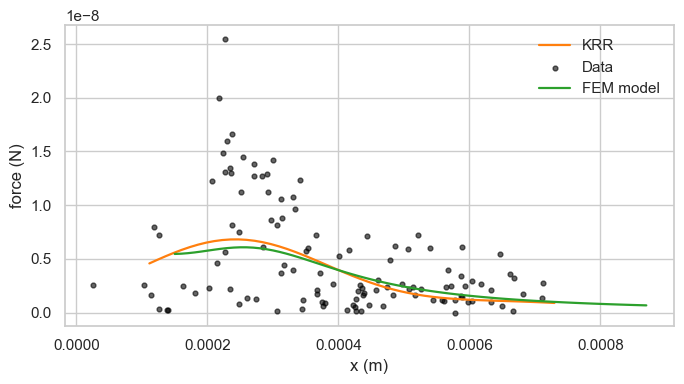

Relative average difference 0.19280215091138553


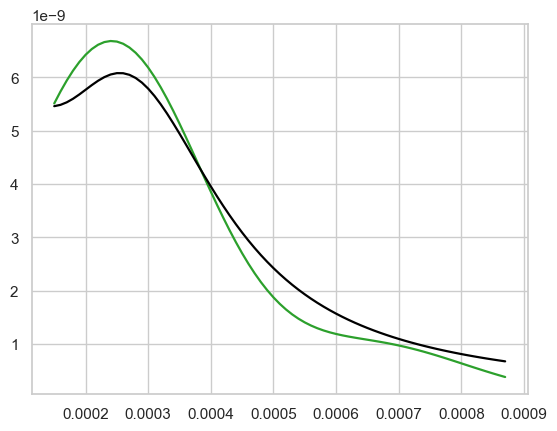

In [156]:
import h5py

with h5py.File("./results/force_model.h5", "r") as f:
    force_control= f["model/force_field"][...]
    f2i = f["model/F2I"][...]
    x_axis = f["model/x"][...]+1.5e-4 #shift the simulation data to match empirical position
    y_axis = f["model/y"][...]
    i_axis = f["model/i"][...]
    
level = 12

i_l = 9
y_l = 29

plt.figure(figsize=(7,4))

mask = xg>1e-4

sl = mm_fit[np.isfinite(mm_fit["currents_level"]) & (np.abs(mm_fit["currents_level"]-(i_axis[i_l])) <= (0.03*np.ptp(i_axis)))]

plt.plot(xg[mask], krr_pred[y_l+1, mask, i_l-1], label="KRR", color="tab:orange", lw=1.6)
plt.scatter(sl["x_m"], sl["force_corr"], color="black", s=12, alpha=0.6, label="Data")
plt.plot(x_axis, force_control[y_l, :, i_l], color="tab:green", lw=1.6, label="FEM model")
plt.xlabel("x (m)"); plt.ylabel("force (N)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


#predict GPR at the simulation points 
X_line = np.stack([x_axis, np.full_like(x_axis, y_axis[y_l]), np.full_like(x_axis, i_axis[i_l])], axis=1)
mu_s_line = krr3.predict(sx.transform(X_line))

# Inverse-transform mean and std to physical units
mu_line = sy.inverse_transform(mu_s_line.reshape(-1, 1)).ravel()

r_diff = np.abs((mu_line - force_control[y_l, :, i_l])/ mu_line)
print("Relative average difference", np.mean(r_diff))

plt.plot(x_axis, mu_line, label="Saved model", color="tab:green", lw=1.6)
plt.plot(x_axis, force_control[y_l, :, i_l], label="Saved model", color="black", lw=1.6)

MSE for KRR: 0.09031934710247577
Negative Log Likelihood (NLL) for KRR: -1148.11


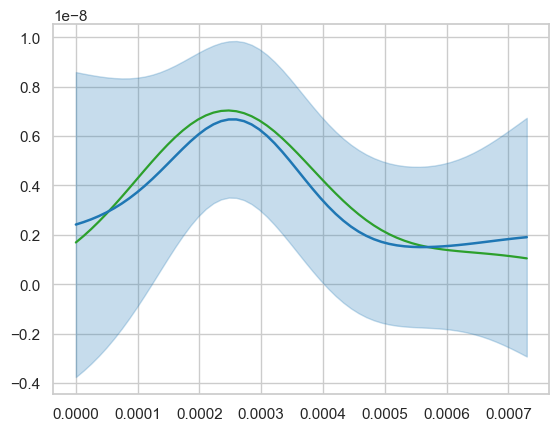

In [54]:
# KRR prediction (assuming krr_pred is [y, x, i])
y_l = 30
i_l = 8

def gaussian_nll(y_true, mu, std):
    # Avoid log(0) and division by zero
    std = np.clip(std, 1e-10, None)
    nll = 0.5 * np.log(2 * np.pi * std**2) + 0.5 * ((y_true - mu) ** 2) / (std ** 2)
    return np.sum(nll)

# MSE for KRR
mse_krr = np.sum(((mu_line - krr_pred[y_l, :, i_l])/std_line)**2)/len(mu_line)
print("MSE for KRR:", mse_krr)

# NLL for KRR
nll_krr = gaussian_nll(krr_pred[y_l, :, i_l], mu_line, std_line)
print(f"Negative Log Likelihood (NLL) for KRR: {nll_krr:.2f}")

plt.plot(xg, krr_pred[y_l, :, i_l], label="Saved model", color="tab:green", lw=1.6)
plt.plot(xg, mu_line, label="GPR mean", color="tab:blue", lw=1.8)
plt.fill_between(xg, mu_line - 2*std_line, mu_line + 2*std_line, color="tab:blue", alpha=0.25, label="GPR ±2σ")

MSE 0.48615616361949865
Negative Log Likelihood (NLL) for GPR: -1382.87


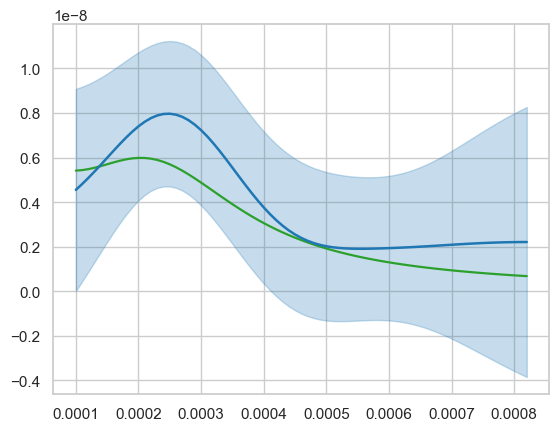

In [102]:
i_l = 9
y_l = 29

#predict GPR at the simulation points 
X_line = np.stack([x_axis, np.full_like(x_axis, y_axis[y_l]), np.full_like(x_axis, i_axis[i_l])], axis=1)
mu_s_line, std_s_line = gpr.predict(sx.transform(X_line), return_std=True)

# Inverse-transform mean and std to physical units
mu_line = sy.inverse_transform(mu_s_line.reshape(-1, 1)).ravel()
std_line = _std_to_physical(sy, mu_s_line, std_s_line)

MSE = np.sum(((mu_line - force_control[y_l, :, i_l])/std_line)**2)/len(mu_line)
print("MSE", MSE)

nll = gaussian_nll(force_control[y_l, :, i_l], mu_line, std_line)
print(f"Negative Log Likelihood (NLL) for GPR: {nll:.2f}")

plt.plot(x_axis, force_control[y_l, :, i_l], label="Saved model", color="tab:green", lw=1.6)
plt.plot(x_axis, mu_line, label="GPR mean", color="tab:blue", lw=1.8)
plt.fill_between(x_axis, mu_line - 2*std_line, mu_line + 2*std_line, color="tab:blue", alpha=0.25, label="GPR ±2σ")